# **Data Preprocessing**

In [1]:
WEIGHTS_V = 36

## *Select Classes*

In [2]:
import pandas as pd
import os

In [3]:
data_path = "../../../data/Datasets/"

train_labels = pd.read_csv(os.path.join(data_path,"train_labels.csv"),names=['sample','id'])
validation_labels = pd.read_csv(os.path.join(data_path,"validation_labels.csv"),names=['sample','id'])
test_labels = pd.read_csv(os.path.join(data_path,"test_labels.csv"),names=['sample','id'])
class_id = pd.read_csv(os.path.join(data_path,"class_id.csv"))


    
train_path = os.path.join(data_path,"train")
val_path = os.path.join(data_path,"val")
test_path = os.path.join(data_path,"test")

train_labels.head()

,sample,id
0,signer0_sample1,41
1,signer0_sample2,104
2,signer0_sample3,205
3,signer0_sample4,26
4,signer0_sample5,191


In [4]:
def check_file(file_path):
    try:
        f = open(file_path)
        f.close()
        return True
    except IOError:
        return False
    
def construct_path(file,path="train"):
    return os.path.join(os.path.join(data_path,path),file+"_color.mp4")

In [5]:
n_classes = 10
actions = list(class_id['EN'][:n_classes])
dic={}
for i,action in enumerate(actions):
    dic[action]=i

In [6]:
def get_data(id,file_path):
    if file_path=="train":
        label_dic = train_labels
    elif file_path=="val":
        label_dic = validation_labels
    elif file_path=="test":
        label_dic = test_labels
        
    
    data =  label_dic[label_dic['id']==id]
    lis =  [construct_path(i,file_path) for i in  (data['sample'])]
    data =  [i for i in lis if check_file(i)]
    return data,[id for i in data]

In [7]:
train_X = [] 
train_Y = []
val_X = [] 
val_Y = []
test_X = [] 
test_Y = []

for i in range(n_classes):
    data,labels = get_data(i,'train')
    train_X.extend(data)
    train_Y.extend(labels)

    
for i in range(n_classes):
    data,labels = get_data(i,'val')
    val_X.extend(data)
    val_Y.extend(labels)

    
for i in range(n_classes):
    data,labels = get_data(i,'test')
    test_X.extend(data)
    test_Y.extend(labels)

In [8]:
video_path = train_X[0]
def_input_path = "../../../data/Datasets/train/"
video_path[len(def_input_path):-4]

'signer0_sample431_color'

# **Dataset**

## *Build Dataset Class*

In [9]:
import sys
sys.path.append("../../../")

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random

from Utils.rgb_frames.data_prepare import get_frames

In [11]:
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class VideoDataset(Dataset):
    def __init__(self, imgs_path, labels, n_frames, transform = None, target_transform=None):
        super(VideoDataset, self).__init__()
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.n_frames = n_frames
        self.imgs_path = imgs_path
    
    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.imgs_path[idx]
        frames = get_frames(video_path=img_path, n_frames=self.n_frames)        
        seed = np.random.randint(1e9)
        if self.transform:
            for i in range(len(frames)):
                random.seed(seed)
                np.random.seed(seed)
                frames[i] = self.transform(frames[i])
        frames = torch.stack(frames)
        
        if self.target_transform:
            label = self.target_transform(label)


        return frames, label

# **Models**

## *Build Models*

#### **1. Conv3D**

In [12]:
import os
import torch
import torch.nn as nn
import torchvision

In [13]:
def convert_relu_to_swish(model: nn.Module):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.SiLU(True))
        else:
            convert_relu_to_swish(child)


In [14]:
class r2plus1d_18(nn.Module):
    def __init__(self, pretrained=True, n_classes=3, dropout_p=0.5):
        super(r2plus1d_18, self).__init__()
        self.pretrained = pretrained
        self.n_classes = n_classes

        model = torchvision.models.video.r2plus1d_18(pretrained=self.pretrained)
        modules = list(model.children())[:-1]
        self.r2plus1d_18 = nn.Sequential(*modules)
        convert_relu_to_swish(self.r2plus1d_18)
        self.fc1 = nn.Linear(model.fc.in_features, self.n_classes)
        self.dropout = nn.Dropout(dropout_p, inplace=True)

    def forward(self, x):
        # (b, f, c, h, w) = x.size()
        # x = x.view(b, c, f, h, w)

        out = self.r2plus1d_18(x)
        out = out.flatten(1)
        out = self.dropout(out)
        out = self.fc1(out)

        return out

# **Implementation**

## *Create training, validation, testing datasets*

In [15]:
model_type = "3dcnn"
# model_type = "rnn"

n_frames = 16

if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 128, 128
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [16]:
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

from Utils.rgb_frames.data_prepare import denormalize

target_transform = transforms.Lambda(lambda y: torch.zeros(n_classes, dtype=torch.float).scatter(0, torch.tensor(y), value=1))
# target_transform = None

In [17]:
train_transformer = transforms.Compose([
                        transforms.Resize((h, w)),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                        ])

params = {
    "imgs_path": train_X,
    "labels": train_Y,
    "n_frames": n_frames,
    "transform": train_transformer,
    "target_transform": target_transform
}

train_ds = VideoDataset(**params)
len(train_ds)

1241

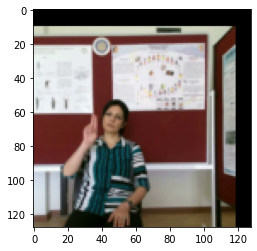

In [18]:
imgs, label = train_ds[0]
plt.imshow(denormalize(imgs[10], mean, std))

In [19]:
val_transformer = transforms.Compose([
                        transforms.Resize((h, w)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                        ])
params = {
    "imgs_path": val_X,
    "labels": val_Y,
    "n_frames": n_frames,
    "transform": val_transformer,
    "target_transform": target_transform
}

val_ds = VideoDataset(**params)
len(val_ds)

190

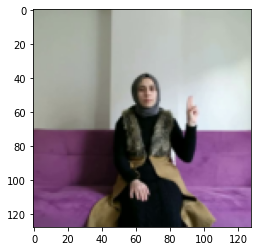

In [20]:
imgs, label = val_ds[10]
plt.imshow(denormalize(imgs[10], mean, std))

In [21]:
test_transformer = transforms.Compose([
                        transforms.Resize((h, w)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                        ])

params = {
    "imgs_path": test_X,
    "labels": test_Y,
    "n_frames": n_frames,
    "transform": test_transformer,
    "target_transform": target_transform
}

test_ds = VideoDataset(**params)
len(test_ds)

168

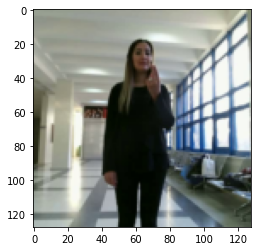

In [22]:
imgs, label = test_ds[10]
plt.imshow(denormalize(imgs[10], mean, std))

## *Create training, validation, testing dataloaders*

In [23]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [l.clone() for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor, labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

batch_size = 4
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_rnn)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_rnn)
else:
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_r3d_18)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_r3d_18)

In [24]:
for xb, yb in train_dl:
    print(xb.shape, yb.shape, yb[0])
    break

for xb, yb in val_dl:
    print(xb.shape, yb.shape, yb[0])
    break

for xb, yb in test_dl:
    print(xb.shape, yb.shape, yb[0])
    break

torch.Size([4, 3, 16, 128, 128]) torch.Size([4, 10]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
torch.Size([4, 3, 16, 128, 128]) torch.Size([4, 10]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([4, 3, 16, 128, 128]) torch.Size([4, 10]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


# *Model Testing*

#### 1. *Load pretrained weights*

In [25]:
import torch
import torch.nn as nn
from Utils.rgb_frames.train_val import loss_epoch

testing_model = r2plus1d_18(pretrained=False, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss(reduction="sum")

best_checkpoint = torch.load("pytorch_weights.tar")
testing_model.load_state_dict(best_checkpoint["model_state_dict"])
loss_fn.load_state_dict(best_checkpoint["loss_state_dict"])

best_checkpoint.keys()

dict_keys(['epochs', 'last_epoch', 'best_epoch', 'model_state_dict', 'optimizer_state_dict', 'lr_scheduler_state_dict', 'loss_state_dict', 'hist'])

In [26]:
best_checkpoint["best_epoch"]

80

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

params_test = {
    "model": testing_model,
    "loss_func": loss_fn,
    "dataset_dl": test_dl,
    "device": device
}

In [28]:
testing_model.eval()
with torch.no_grad():
    testing_loss, testing_metric = loss_epoch(**params_test)

print("dev loss: %.6f, accuracy: %.2f" %(testing_loss,100*testing_metric))

100%|███████████████████████████████████████████| 42/42 [00:19<00:00,  2.12it/s]

dev loss: 0.347164, accuracy: 89.88


# save predections

In [29]:
from tqdm import tqdm
def evaluate_epoch(model, loss_func, dataset_dl, device, opt=None):
    output_collection = []
    for xb, yb in tqdm(dataset_dl):
        xb, yb = xb.to(device), yb.to(device)
        model = model.to(device)
        output=model(xb)
        output_collection.append(output)
    return output_collection

In [30]:
params_test = {
    "model": testing_model,
    "loss_func": loss_fn,
    "dataset_dl": test_dl,
    "device": device
}

In [31]:
testing_model.eval()
with torch.no_grad():
    lis = evaluate_epoch(**params_test)

print("dev loss: %.6f, accuracy: %.2f" %(testing_loss,100*testing_metric))

100%|███████████████████████████████████████████| 42/42 [00:10<00:00,  4.09it/s]

dev loss: 0.347164, accuracy: 89.88


In [32]:
arr = None

for batch in lis:
    if type(arr) == np.ndarray:
        arr = np.concatenate([arr,batch.cpu().detach().numpy()])
    else:
        arr = batch.cpu().detach().numpy()



In [33]:
arr.shape

(168, 10)

In [35]:
np.save("predections_test/pytorch.npy",arr)